# Does weather affect a journey span?

In this analysis, data on trips using cabs during November 2017 in Chicago are provided. The weather during the month was fluctuating. And we want to know if people's taxi riding pattern is different in different weather conditions.

Hence, the purpose of this analysis are:

1. To observe the top 10 most popular dropoff neighborhoods during November 2017

2. To observe number of trips that each company cab makes during 15 to 16 November 2017

3. To test a hypothesis: "the average of trip duration from Loop to O'Hare airport in raining Saturdays is different from any other time"

In [5]:
# import libraries
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import scipy.stats as st

In [6]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
# load dataset
cabs_co = pd.read_csv('/content/gdrive/MyDrive/data_projects/project_sql_result_01.csv')
drops = pd.read_csv('/content/gdrive/MyDrive/data_projects/project_sql_result_04.csv')
loop_ohare = pd.read_csv('/content/gdrive/MyDrive/data_projects/project_sql_result_07.csv')

## Data Pre-processing and Cleansing

In [8]:
# load data sample
cabs_co.head()

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


In [9]:
# load data sample
drops.head()

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


In [10]:
# load data sample
loop_ohare.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


In [11]:
# load general info
cabs_co.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [12]:
# load general info
drops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [13]:
# load statistical description
cabs_co.describe()

,trips_amount
count,64.000000
mean,2145.484375
std,3812.310186
min,2.000000
25%,20.750000
50%,178.500000
75%,2106.500000
max,19558.000000


In [14]:
# load statistical description
drops.describe()

,average_trips
count,94.000000
mean,599.953728
std,1714.591098
min,1.800000
25%,14.266667
50%,52.016667
75%,298.858333
max,10727.466667


In [15]:
# load statistical description
loop_ohare.describe()

,duration_seconds
count,1068.000000
mean,2071.731273
std,769.461125
min,0.000000
25%,1438.250000
50%,1980.000000
75%,2580.000000
max,7440.000000


In [16]:
# simplify columns naming
cabs_co.columns = ['company', 'sum_trips']
cabs_co.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   company    64 non-null     object
 1   sum_trips  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [17]:
# simplify columns naming
drops.columns = ['location', 'avg_trips']
drops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   location   94 non-null     object 
 1   avg_trips  94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [18]:
# check unique values
cabs_co.company.value_counts()

Flash Cab                      1
Taxi Affiliation Services      1
Norshore Cab                   1
6742 - 83735 Tasha ride inc    1
3591 - 63480 Chuks Cab         1
                              ..
Gold Coast Taxi                1
Service Taxi Association       1
5 Star Taxi                    1
303 Taxi                       1
3556 - 36214 RC Andrews Cab    1
Name: company, Length: 64, dtype: int64

In [19]:
# check unique values
drops.location.value_counts()

Loop               1
Chatham            1
Clearing           1
Auburn Gresham     1
Washington Park    1
                  ..
Albany Park        1
Wicker Park        1
Avondale           1
Hyde Park          1
Riverdale          1
Name: location, Length: 94, dtype: int64

In [20]:
# load data with too-short trip duration in loop_ohare
loop_ohare.loc[loop_ohare.duration_seconds < 300].reset_index()

,index,start_ts,weather_conditions,duration_seconds
0,15,2017-11-25 13:00:00,Good,60.0
1,163,2017-11-11 09:00:00,Good,0.0
2,168,2017-11-11 07:00:00,Good,0.0
3,204,2017-11-18 19:00:00,Good,0.0
4,552,2017-11-04 01:00:00,Good,0.0
5,801,2017-11-04 09:00:00,Good,0.0
6,1063,2017-11-25 11:00:00,Good,0.0


From the pre-processing steps it appears that:

1. No missing values

2. No duplicates

3. Data type is suitable

4. Data range in both of datasets cabs_co and drops are very wide, with large variance and mean far from median

5. In dataset loop_ohare the mean and median is very close that is around 33 to 34 minutes. The longest trip takes about 2 hours, and the shortest is 0.

6. In dataset loop_ohare, there is a trip that lasts for 5 minutes and there are 6 trips that actually last not a second. Rows with 0 second will be dropped. It should not change the dataset too much because their insignificant numbers compared to 1,068 total data.

In [21]:
# slice only trips last a least for 5 minutes
loop_ohare = loop_ohare.loc[loop_ohare.duration_seconds >= 300]

In [22]:
# re-check general info 
loop_ohare.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1061 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1061 non-null   object 
 1   weather_conditions  1061 non-null   object 
 2   duration_seconds    1061 non-null   float64
dtypes: float64(1), object(2)
memory usage: 33.2+ KB


Now that 0 second trip in dataset loop_ohare has been dropped, steps on further analysis can start.

## Top 10 most popular dropoff neighborhoods in November 2017

In [23]:
# slice drops for 10 locations with highest average number of trips
drops_10 = drops.nlargest(10,'avg_trips')
drops_10

,location,avg_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


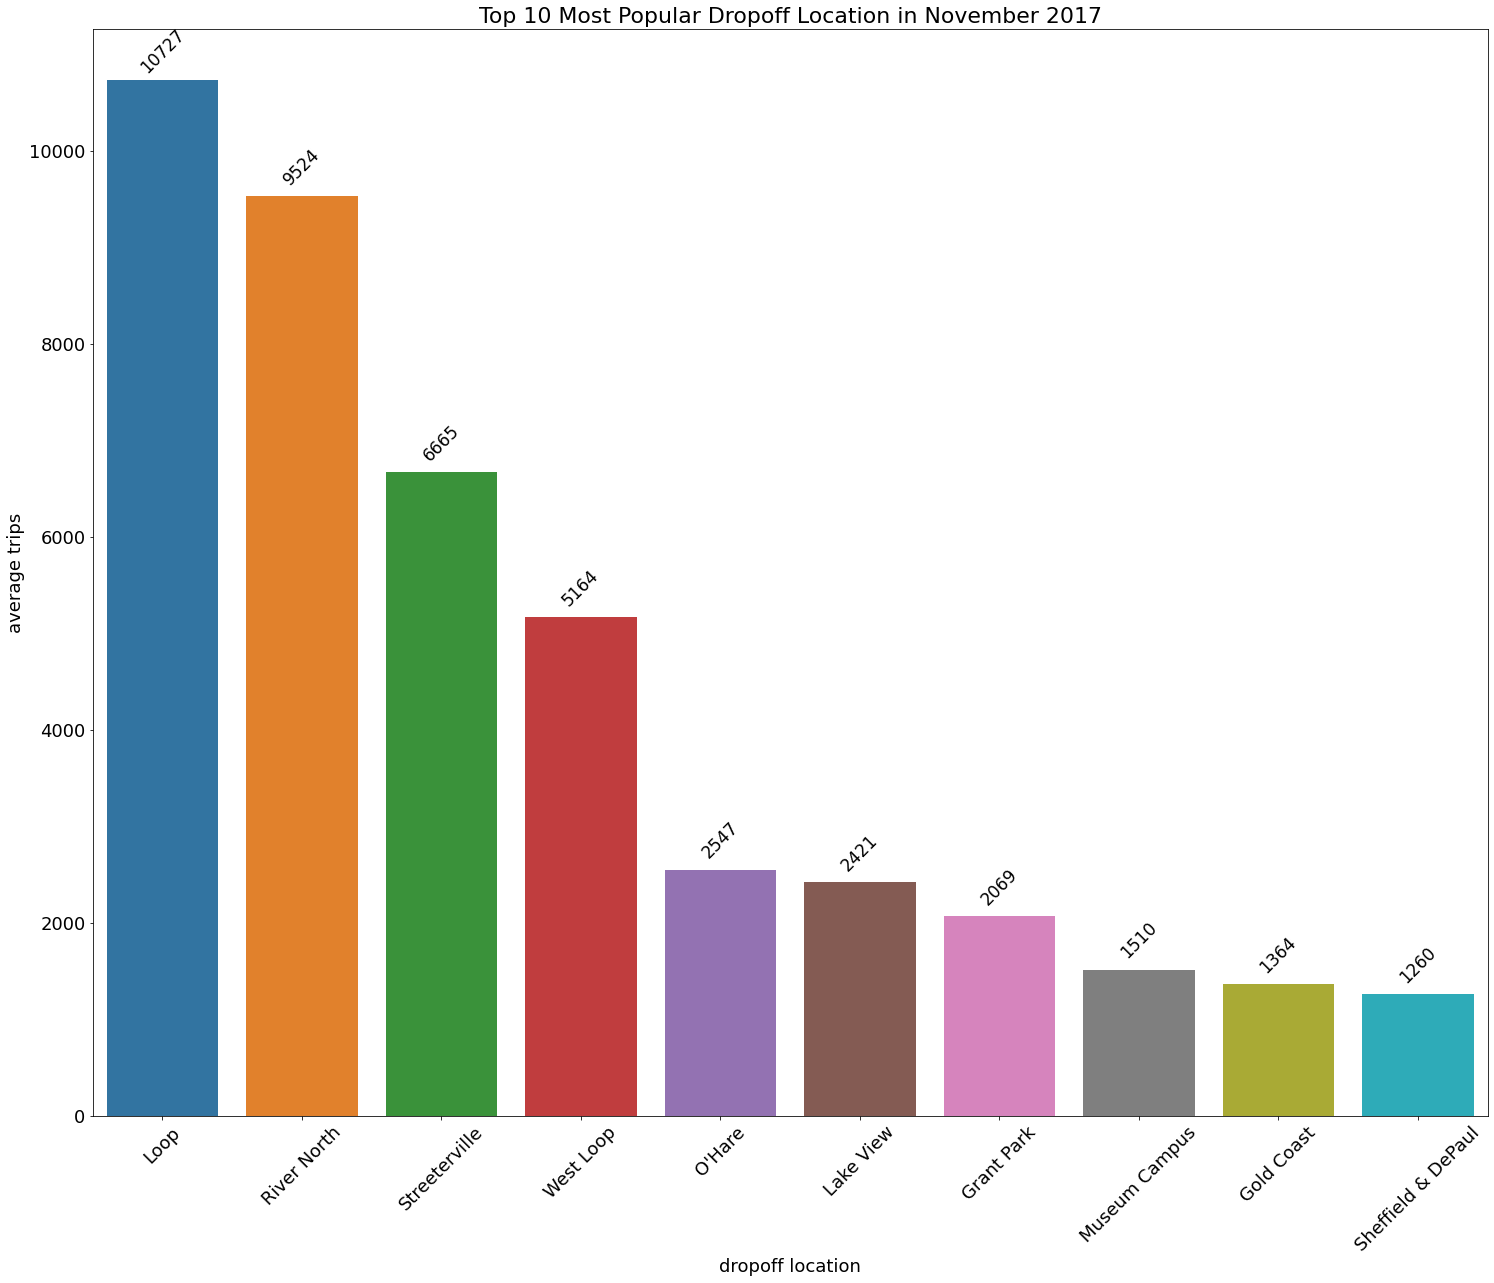

In [24]:
# load graph for dropoff locations
plt.figure(figsize=(25,20)) # scale up figure size
splot = sns.barplot(data=drops_10, x='location', y='avg_trips') # assign plot to object

for g in splot.patches:
    splot.annotate(format(g.get_height(), '.0f'), # 0 decimals on label value
                   (g.get_x() + g.get_width()/2, # help position the label x-axis-wise
                    g.get_height()), # help position the label y-axis-wise
                   fontsize=17, #font size plot
                   ha = 'center', va = 'center', # center label horizontally and vertically to plot
                   xytext = (0, 30), rotation=45, # distant 30 pixel from plot, rotate label on plot 45
                   textcoords = 'offset points')
plt.title('Top 10 Most Popular Dropoff Location in November 2017', fontsize=22)
plt.ylabel('average trips',fontsize=18)
plt.xlabel('dropoff location',fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18,rotation = 45)
plt.show()

### Interim Conclusion

The first most popular dropoff neighborhood in November is Loop with an average of 10,727 trips made during the month. And the 10th is Sheffield & DePaul with an average of 1,259. While O'hare Airport made the 5th position. 

It seems that most popular dropoff neighborhoods are places for central business like Loop, or those with arts attractions and museums like River North and Streeterville, or highly populated district ones like Lake View, or places with many bars, restaurants, and cafe like Sheffield & DePaul.

## Cab Companies with Most Trips in 15 to 16 November 2017

In [25]:
# slice cabs_co for 10 most number of trips
cabs_co_10 = cabs_co.nlargest(10,'sum_trips')
cabs_co_10

,company,sum_trips
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
5,Chicago Carriage Cab Corp,9181
6,City Service,8448
7,Sun Taxi,7701
8,Star North Management LLC,7455
9,Blue Ribbon Taxi Association Inc.,5953


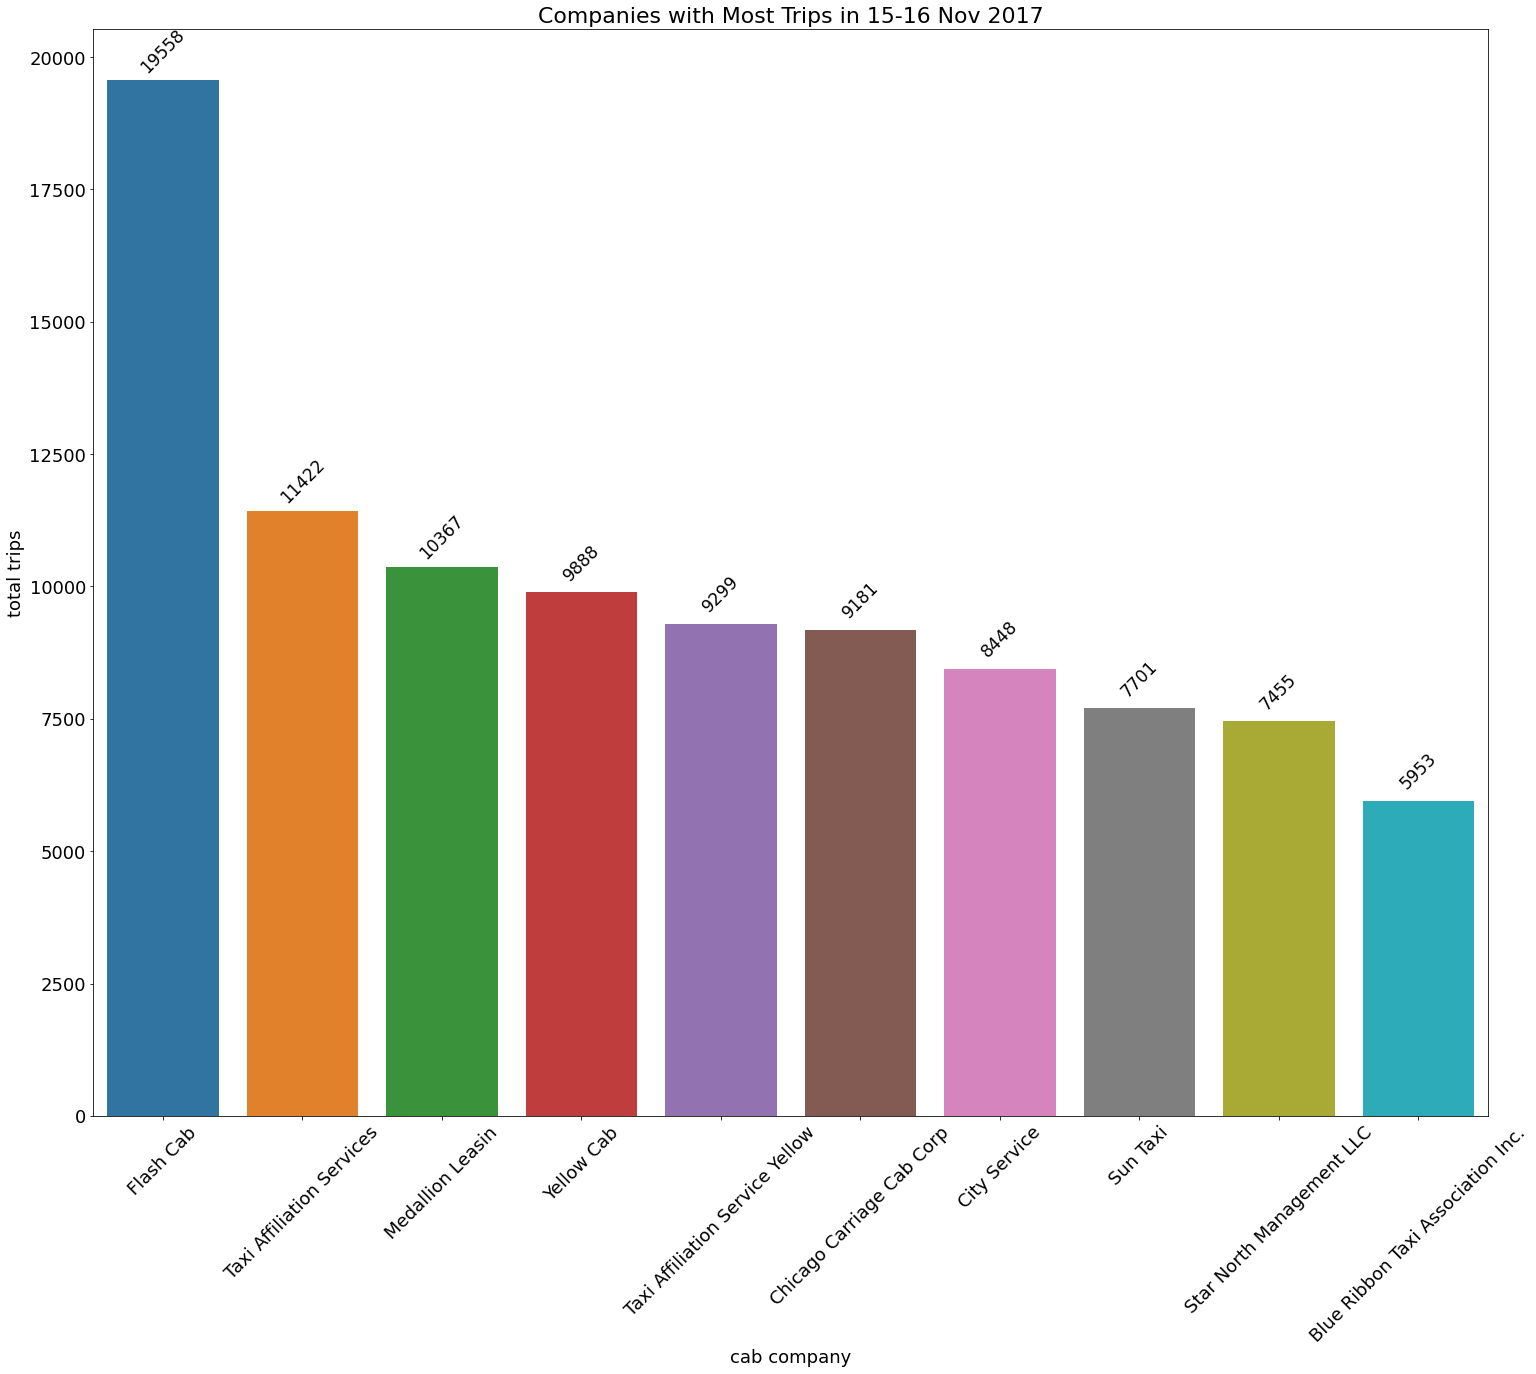

In [26]:
# load graph for cab companies
plt.figure(figsize=(25,20)) # scale up figure size
cplot = sns.barplot(data=cabs_co_10, x='company', y='sum_trips') # assign plot to object

for g in cplot.patches:
    cplot.annotate(format(g.get_height(), '.0f'), # 0 decimals on label value
                   (g.get_x() + g.get_width()/2, # help position the label x-axis-wise
                    g.get_height()), # help position the label y-axis-wise
                   fontsize=17, #font size plot
                   ha = 'center', va = 'center', # center label horizontally and vertically to plot
                   xytext = (0, 30), rotation=45, # distant 30 pixel from plot, rotate label on plot 45
                   textcoords = 'offset points')
plt.title('Companies with Most Trips in 15-16 Nov 2017', fontsize=22)
plt.ylabel('total trips',fontsize=18)
plt.xlabel('cab company',fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18,rotation = 45)
plt.show()

### Interim Conclusion

The company with most trips made during 15 to 16 November 2017 is Flash Cab with total of 19,558 trips. This means it made more than 600 trips per day during the month.

It significantly outperformed all other companies, with almost double the number 2 company's, Taxi Affiliation Service, trips. And the number 10 is Blue Ribbon Taxi Association Inc.

## Loop to O'Hare
In this step, testing of below hypothesis is done:


"The average of trip duration from Loop to O'Hare airport in raining Saturdays is different from any other time"

In [27]:
# pivot dataset to find average duration for each weather condition
loop_ohare.pivot_table(index='weather_conditions', values='duration_seconds', aggfunc='mean')

,duration_seconds
weather_conditions,
Bad,2427.205556
Good,2015.496027


In [28]:
# slice dataset for Good weather
good = loop_ohare.loc[loop_ohare.weather_conditions == 'Good']
good = good['duration_seconds']
good.describe()

count     881.000000
mean     2015.496027
std       741.064793
min       420.000000
25%      1404.000000
50%      1800.000000
75%      2460.000000
max      7440.000000
Name: duration_seconds, dtype: float64

In [29]:
# slice dataset for Bad weather
bad = loop_ohare.loc[loop_ohare.weather_conditions == 'Bad']
bad = bad['duration_seconds']
bad.describe()

count     180.000000
mean     2427.205556
std       721.314138
min       480.000000
25%      1962.000000
50%      2540.000000
75%      2928.000000
max      4980.000000
Name: duration_seconds, dtype: float64

In Saturdays with good weather the trip duration has data distribution that looks like:

1. median is 30 minutes, 

2. mean is 33 minutes, 

3. the shortest trip is 7 minutes, and

4. the longest trip is 124 minutes. 



In Saturdays with bad weather the trip duration has data distribution that looks like: 

1. median is 42 minutes, 

2. mean is 40 minutes, 

3. the shortest trip is 8 minutes, and

4. and the longest trip is 83 minutes.

Text(0.5, 1.0, 'Trip Duration at Each Weather Condition')

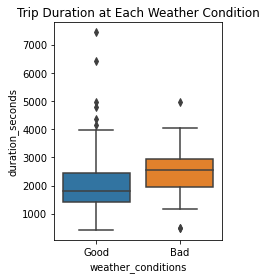

In [30]:
# Load boxplot to check on outliers in each category
plt.figure(figsize=(3,4))
sns.boxplot(data=loop_ohare, y='duration_seconds', x='weather_conditions')
plt.title('Trip Duration at Each Weather Condition')


From the boxplot it appears that Good weather has more outliers than what Bad has. 

Also, Bad has top 75 percent of data lie on seconds (1,962 seconds) more than top 50% data that Good has lie on (1,800 seconds).

In the following step, the hypothesis will be tested.

In [31]:
# Load variance
var_good = np.var(good)
var_bad = np.var(bad)
var_good, var_bad

(548553.6710965894, 517403.56330246915)

In [32]:
# Load Standard Deviation
np.sqrt(var_good), np.sqrt(var_bad)

(740.6440920554146, 719.3076972356608)

In testing whether trip duration in good weather and bad weather is the same, alpha is set at 10%. This is because of the small numbers of population (less than 1,000).

Variance of Good is 548,553 and Bad is 517,403. Although variances of both sample seems quite similar, a levene test will be done to test if both variances are in average the same.

In [33]:
# set alpha at 10%
alpha = 0.1

In [34]:
# Make a levene test on how both variances vary
p_value_levene = st.levene(good,bad).pvalue
print(p_value_levene)

if p_value_levene < alpha:
    print('Reject H0: Variances are not equal')
else:
    print('Fail to reject H0: There is insufficient evidence that the variances are not equal')

0.6919725583970324
Fail to reject H0: There is insufficient evidence that the variances are not equal


From the Levene test, it is found that the two variances are equal.

Next, the hypothesis will be tested using statistical ttest for independent samples.

H0 = average of trip duration in good Saturdays and bad Saturdays is the same

H1 = average of trip duration in good Saturdays and bad Saturdays is not the same

In [35]:
# Testing the hypothesis using ttest_ind method
results = st.ttest_ind(good, bad, equal_var=True)
print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Reject hypothesis null")
else:
    print("Fail to reject hypothesis null")

p-value: 1.5028117595948955e-11
Reject hypothesis null


### Interim Conclusions

In testing hypothesis that the average of trip duration from Loop to O'Hare airport in raining Saturdays is different from any other time, an independent test using scipy.stats.ttest_ind method is applied.

Alpha is set at 10% because of the population being small.

Equal_var argument is set to true because the levene test shows that the variances of both samples are equal.

Result of the testing shows that H0 is rejected. This means it can be concluded that trip duration in good weather and bad weather is different in average.

From the means, it is known that average trip duration in bad weather is longer than in good weather.

## Final Conclusions

From exploratory data anaylsis it is found that:

1. The most popular dropoff neighborhood during November 2017 is Loop. It seems that most popular dropoff neighborhoods are places for central business, or those with arts attractions and museums like River North and Streeterville, or highly populated district ones, or places with many bars, restaurants.

2. The cab company with most trips made during 15 to 16 November 2017 is Flash Cab which significantly outperformed all other companies, and almost double the rank 2 company.

From the statisitical hypothesis testing, it is concluded that the average of trip duration from Loop to O'Hare airport in raining Saturdays is different from any other time.